# Phase 4: Template-to-Template Evaluation

This notebook contains results evaluating the correspondence between BigBrain and ICBM2009b. Use Case for BigBrain vs ICBM2009b (Sym).

In [1]:
# initialize libraries
library(plyr)
library(digest)
library(reshape2)
library(ggplot2)

In [2]:
# useful functions

# calculate the distance between two sets of coordinates
dist3D <- function(coord1, coord2) { # vector X,Y,Z
        xdist <- coord1[1] - coord2[1] # could also write as coord1$X, etc.
        ydist <- coord1[2] - coord2[2]
        zdist <- coord1[3] - coord2[3]
        euclidean_dist <- sqrt(xdist^2+ydist^2+zdist^2)
        return(as.numeric(unlist(euclidean_dist)))
}

# calculate the pairwise distance between an array of 3D coordinates
pairwise_dist3D <- function(temp_coords) { # labeled X,Y,Z
        N <- length(temp_coords$X)
        dist_vec <- rep(0,N) # create vector
        sum_dist <- 0 # initialize to zero
        count <- 0
        for (i in 1:(N-1)) {
                for (j in (i+1):N) {
                        if (i != j) {
                                count <- count + 1
                                first_coord <- temp_coords[i,]
                                second_coord <- temp_coords[j,]
                                curr_dist <- dist3D(first_coord, second_coord)
                                sum_dist <- sum_dist + curr_dist
                                dist_vec[count] <- curr_dist
                        }
                }
        }
        return(c(as.numeric(unlist(mean(dist_vec))),as.numeric(unlist(sd(dist_vec)))))
}

In [3]:
# initialize variables and load in raw fcsv data into df_raters
setwd('~/GitHub/afids-analysis/data/PHASE4_input_afid/')

df_afid <- read.table('~/GitHub/afids-analysis/etc/afids.csv', sep=",", header=TRUE)

df_raters <- data.frame(fid=integer(),X=double(),Y=double(),Z=double(),rater=factor(),
                        template=factor(),mri_type=factor(),session=integer(),date=integer(),
                        name=character(),description=character(),stringsAsFactors = FALSE)
csv_files <- list.files(".", "*.fcsv")

for (i in 1:length(csv_files)) {
    curr_split <- unlist(strsplit(csv_files[i],"_"))
    if (length(curr_split)>1) { # extract name and session data
        rater_template <- curr_split[1]
        rater_mri_type <- curr_split[2]
        rater_name <- curr_split[3]
        rater_session <- as.numeric(curr_split[4])
        rater_date <- as.numeric(unlist(strsplit(curr_split[5],"[.]"))[1])
    }
    curr_rater <- read.table(csv_files[i], header=FALSE, sep=",")
    df_rater <- data.frame(fid = 1:length(curr_rater$V1))

    df_rater <- cbind(df_rater,X=curr_rater[2],Y=curr_rater[3],Z=curr_rater[4],rater=rater_name,
                    template=rater_template,mri_type=rater_mri_type,
                    session=rater_session,date=rater_date,name=curr_rater[12],
                    description=curr_rater[13])
  
    df_rater <- rename(df_rater, c("V2"="X","V3"="Y","V4"="Z","V12"="name","V13"="description"))
    df_raters <- rbind(df_raters,df_rater)
}

levels(df_raters$rater) <- 1:8
#str(df_raters)

# bring in ICBM2009bAsym
df_ICBM2009bAsym_mean <- data.frame(fid=integer(),X=double(),Y=double(),Z=double(),stringsAsFactors = FALSE)
ICBM2009bAsym_file <- "~/GitHub/afids-analysis/data/PHASE1_output_afid_postQC/MNI152NLin2009bAsym_MEAN_postQC.fcsv"

curr_template <- read.table(ICBM2009bAsym_file, header=FALSE, sep=",")
df_template <- data.frame(fid = 1:length(curr_template$V1))
df_template <- cbind(df_template,X=curr_template[2],Y=curr_template[3],Z=curr_template[4])
df_template <- rename(df_template, c("V2"="X","V3"="Y","V4"="Z"))
df_ICBM2009bAsym_mean <- df_template


In [4]:
# mean coordinates for each landmark placement for each template/session
df_mean <- ddply(df_raters, .(template, fid), summarize, X=mean(X), Y=mean(Y), Z=mean(Z))

# initialize
df_raters$mean_AFLE <- rep(0, length(df_raters$fid))
df_raters$outlier <- NA

df_raters$xdist <- NA
df_raters$ydist <- NA
df_raters$zdist <- NA
for (i in 1:dim(df_raters)[1]) {
        curr_rater <- df_raters[i,]
        
        # set current mean based on template, session, fid
        mean_raters <- subset(df_mean, template == curr_rater$template & fid == curr_rater$fid)
        
        df_raters[i,]$xdist <- curr_rater$X - mean_raters$X
        df_raters[i,]$ydist <- curr_rater$Y - mean_raters$Y
        df_raters[i,]$zdist <- curr_rater$Z - mean_raters$Z
        curr_coords <- curr_rater[,2:4]
        mean_coords <- mean_raters[,3:5]
        df_raters[i,]$mean_AFLE <- dist3D(curr_coords, mean_coords)
        df_raters[i,]$outlier <- (df_raters[i,]$mean_AFLE > 10) # focus on true outliers (1cm+) first
}

# Validation of AFID Placements

Two expert raters and one additional expert rater overlooking the placements.

In [5]:
# summary of findings
all_subjects <- subset(df_raters, session > 0) # ignore session 0 which was from the group tutorial
num_outliers <- sum(subset(all_subjects, outlier == TRUE)$outlier)
num_total <- length(all_subjects$outlier)

sprintf( "Total: %.2f +/- %.2f mm; Outliers: %d/%d (%.2f%%)",
        mean(all_subjects$mean_AFLE), sd(all_subjects$mean_AFLE),
        num_outliers, num_total, (num_outliers/num_total)*100 )

# summary of results for each scan that was annotated
summary_subjects_df <- ddply(df_raters, .(template), summarize, mean=mean(mean_AFLE), sd=sd(mean_AFLE))
summary_bbsym_df <- ddply(subset(df_raters, template == 'BigBrain'), .(fid), summarize, mean=mean(mean_AFLE), sd=sd(mean_AFLE))
summary_sym_df <- ddply(subset(df_raters, template == 'MNI152NLin2009bSym'), .(fid), summarize, mean=mean(mean_AFLE), sd=sd(mean_AFLE))

summary_subjects_df[,-1] <- round(summary_subjects_df[,-1],2)
summary_subjects_df

#summary_bb_afids_df
#summary_sym_afids_df

[1] "Total: 0.59 +/- 0.40 mm; Outliers: 0/128 (0.00%)"

template,mean,sd
BigBrain,0.63,0.50
MNI152NLin2009bSym,0.55,0.26


In [6]:
# start by calculating mean coordinates
df_template_mean <- data.frame(fid=integer(),X=double(),Y=double(),Z=double(),
                        template=factor(), name=factor(),description=character(),stringsAsFactors = FALSE)
df_template_sd <- data.frame(fid=integer(),X=double(),Y=double(),Z=double(),
                        template=factor(), name=factor(),description=character(),stringsAsFactors = FALSE)

# iterate over each template and compute the mean and standard deviation
for (curr_template in levels(df_raters$template)) {
    for (i in 1:32) { # for each AFID32 point, calculate the mean
        df_subset <- subset(df_raters, fid == i & template == curr_template)
        curr_fid_name <- df_afid$name[i]
        curr_fid_desc <- df_afid$description[i]
        df_curr_fid <- data.frame(fid = i, X = mean(df_subset$X), Y = mean(df_subset$Y), Z = mean(df_subset$Z),
                        template=curr_template, name=curr_fid_name, description=curr_fid_desc)
        df_template_mean <- rbind(df_template_mean, df_curr_fid)
        df_curr_fid_sd <- data.frame(fid = i, X = sd(df_subset$X), Y = sd(df_subset$Y), Z = sd(df_subset$Z),
                        template=curr_template, name=curr_fid_name, description=curr_fid_desc)
        df_template_sd <- rbind(df_template_sd, df_curr_fid_sd)
    }
}

##########################################################################################
# BigBrain
##########################################################################################
df_BigBrain_mean <- subset(df_template_mean, template == 'BigBrain')
df_BigBrain_fcsv <- data.frame(id=paste('vtkMRMLMarkupsFiducialNode',df_BigBrain_mean$fid,sep="_"),x=df_BigBrain_mean$X,y=df_BigBrain_mean$Y,z=df_BigBrain_mean$Z,
                               ow=0,ox=0,oy=0,oz=1,
                               vis=1,sel=1,lock=0,label=df_BigBrain_mean$fid,desc=df_afid$description,
                               associatedNodeID='vtkMRMLScalarVolumeNode1',stringsAsFactors = FALSE)

# write out table (need to use file connection approach because of multiple header lines required by Slicer)
fio <- file('~/GitHub/afids-analysis/data/PHASE4_output_afid/BigBrain_MEAN.fcsv', open="wt")
  writeLines(paste('# Markups fiducial file version = 4.6'),fio)
  writeLines(paste('# CoordinateSystem = 0'),fio)
  writeLines(paste('# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID'),fio)
  write.table(df_BigBrain_fcsv,fio,sep=',',quote=FALSE,col.names=FALSE,row.names=FALSE)
close(fio)

##########################################################################################
# ICBM2009bSym
##########################################################################################
df_ICBM2009bSym_mean <- subset(df_template_mean, template == 'MNI152NLin2009bSym')
df_ICBM2009bSym_fcsv <- data.frame(id=paste('vtkMRMLMarkupsFiducialNode',df_ICBM2009bSym_mean$fid,sep="_"),x=df_ICBM2009bSym_mean$X,y=df_ICBM2009bSym_mean$Y,z=df_ICBM2009bSym_mean$Z,
                               ow=0,ox=0,oy=0,oz=1,
                               vis=1,sel=1,lock=0,label=df_ICBM2009bSym_mean$fid,desc=df_afid$description,
                               associatedNodeID='vtkMRMLScalarVolumeNode1',stringsAsFactors = FALSE)

# write out table (need to use file connection approach because of multiple header lines required by Slicer)
fio <- file('~/GitHub/afids-analysis/data/PHASE4_output_afid/MNI152NLin2009bSym_MEAN.fcsv', open="wt")
writeLines(paste('# Markups fiducial file version = 4.6'),fio)
writeLines(paste('# CoordinateSystem = 0'),fio)
writeLines(paste('# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID'),fio)
write.table(df_ICBM2009bSym_fcsv,fio,sep=',',quote=FALSE,col.names=FALSE,row.names=FALSE)
close(fio)

# BigBrainSym versus ICBM2009b Sym

BigBrain has been pre-registered to ICBM2009b Sym and available as a package online. Here we evaluated the spatial correspondence between these two templates.

In [7]:
# calculate distances between BigBrainSym and Sym
bbsym_vs_sym <- dist3D(df_BigBrain_mean[,2:4],df_ICBM2009bSym_mean[,2:4])

sprintf( "Total: %.2f +/- %.2f mm",
        mean(bbsym_vs_sym), sd(bbsym_vs_sym) )

summary_bbsym_vs_sym <- cbind(df_afid, bbsym_vs_sym)
names(summary_bbsym_vs_sym)[4] <- 'AFRE'

summary_bbsym_vs_sym[,-3:-1] <- round(summary_bbsym_vs_sym[,-3:-1],2)
#summary_bbsym_vs_sym

[1] "Total: 2.16 +/- 1.99 mm"

## Is there any correlation of the errors reported with FLE?

Here we take our computed AFLE values for BigBrain-Sym and ICBM2009b-Sym and find that there is no correlation with the AFRE found.

In [8]:
#  Is there any correlation of the errors you report with FLE?
#plot(summary_bbsym_vs_sym$AFRE, summary_bbsym_df$mean, xlim = c(0,10), ylim = c(0,10))

# against BigBrain-Sym AFLE
cor.test(summary_bbsym_vs_sym$AFRE, summary_bbsym_df$mean, method = 'kendall')

# against ICBM2009b-Sym AFLE
cor.test(summary_bbsym_vs_sym$AFRE, summary_sym_df$mean, method = 'kendall')

Warning message in cor.test.default(summary_bbsym_vs_sym$AFRE, summary_bbsym_df$mean, :
“Cannot compute exact p-value with ties”


	Kendall's rank correlation tau

data:  summary_bbsym_vs_sym$AFRE and summary_bbsym_df$mean
z = -0.37303, p-value = 0.7091
alternative hypothesis: true tau is not equal to 0
sample estimates:
        tau 
-0.04641778 


Warning message in cor.test.default(summary_bbsym_vs_sym$AFRE, summary_sym_df$mean, :
“Cannot compute exact p-value with ties”


	Kendall's rank correlation tau

data:  summary_bbsym_vs_sym$AFRE and summary_sym_df$mean
z = 0.56765, p-value = 0.5703
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.07063576 


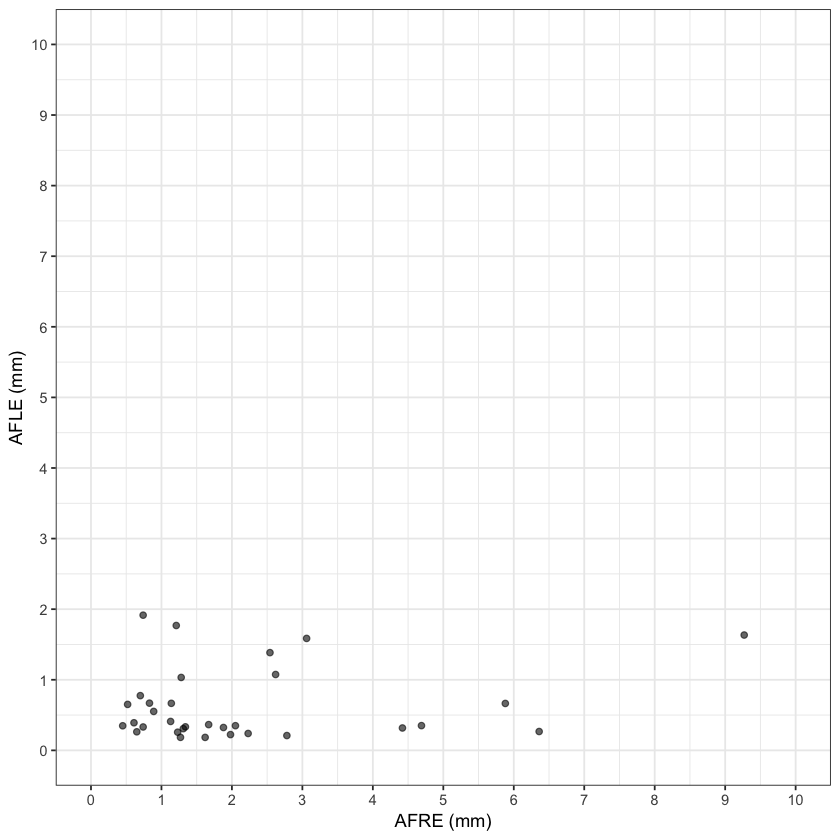

In [9]:
## plot of AFLE and AFRE
plot_df <- cbind(summary_bbsym_vs_sym, summary_bbsym_df)
ggplot(plot_df, aes(AFRE, mean)) +
    geom_point(alpha = 0.6) +
    scale_x_continuous(breaks=c(seq(0,10,1))) +
    scale_y_continuous(breaks=c(seq(0,10,1))) +
    coord_cartesian(xlim=c(0, 10), ylim=c(0, 10)) +
    labs(x = "AFRE (mm)", y = "AFLE (mm)") +
    theme_bw()

# BigBrainSym versus ICBM2009b Asym

Here we evaluated the spatial correspondence between BigBrainSym and MNI2009bAsym (asymmetric) knowing that BigBrainSym was registered to MNI2009bSym rather than MNI2009bAsym. AFRE should be higher than for MNI2009bSym.

In [10]:
# calculate distances between BigBrainSym and Sym
bbsym_vs_asym <- dist3D(df_BigBrain_mean[,2:4],df_ICBM2009bAsym_mean[,2:4])

sprintf( "Total: %.2f +/- %.2f mm",
        mean(bbsym_vs_asym), sd(bbsym_vs_asym) )

summary_bbsym_vs_asym <- cbind(df_afid, bbsym_vs_asym)
names(summary_bbsym_vs_asym)[4] <- 'AFRE'

summary_bbsym_vs_asym[,-3:-1] <- round(summary_bbsym_vs_asym[,-3:-1],2)
#summary_bbsym_vs_asym

[1] "Total: 2.30 +/- 1.83 mm"

# ICBM2009b: Sym versus Asym

Here we evaluated the distance between AFIDs for ICBM2009b sym and asym templates. Note that calling the difference AFRE is not technically correct as the two templates are not aligned to one another. However, the syntax was kept the same for simplicity.

In [11]:
# calculate distances between asym and sym
asym_vs_sym <- dist3D(df_ICBM2009bAsym_mean[,2:4],df_ICBM2009bSym_mean[,2:4])

sprintf( "Total: %.2f +/- %.2f mm",
        mean(asym_vs_sym), sd(asym_vs_sym) )

summary_asym_vs_sym <- cbind(df_afid, asym_vs_sym)
names(summary_asym_vs_sym)[4] <- 'AFRE'

summary_asym_vs_sym[,-3:-1] <- round(summary_asym_vs_sym[,-3:-1],2)
#summary_asym_vs_sym

[1] "Total: 0.88 +/- 0.68 mm"

## Is there any correlation of the errors reported with FLE?

Here we take our computed AFLE values for ICBM2009b-Asym and ICBM2009b-Sym and find that there is no correlation with the AFRE found.

In [12]:
#  Is there any correlation of the errors you report with FLE?
# against ICBM2009b-Sym AFLE
cor.test(summary_asym_vs_sym$AFRE, summary_sym_df$mean, method = 'kendall')

Warning message in cor.test.default(summary_asym_vs_sym$AFRE, summary_sym_df$mean, :
“Cannot compute exact p-value with ties”


	Kendall's rank correlation tau

data:  summary_asym_vs_sym$AFRE and summary_sym_df$mean
z = 1.687, p-value = 0.09161
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.2101014 


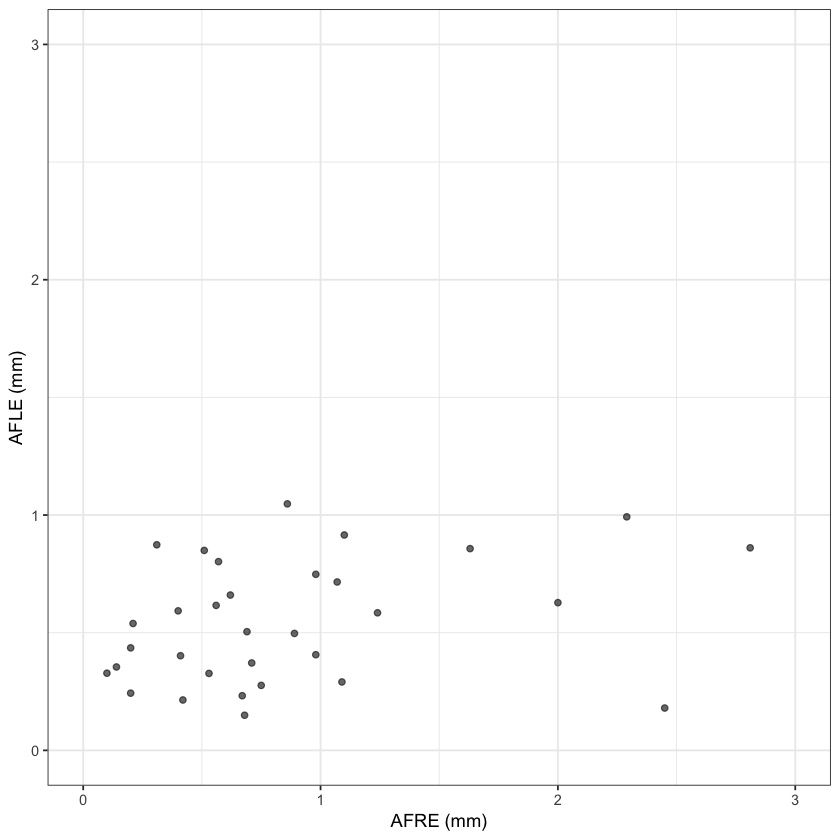

In [13]:
# plot
#plot(summary_asym_vs_sym$AFRE, summary_sym_df$mean, xlim = c(0,3), ylim = c(0,3))
## plot of AFLE and AFRE
plot_df <- cbind(summary_asym_vs_sym, summary_sym_df)
ggplot(plot_df, aes(AFRE, mean)) +
    geom_point(alpha = 0.6) +
    scale_x_continuous(breaks=c(seq(0,3,1))) +
    scale_y_continuous(breaks=c(seq(0,3,1))) +
    coord_cartesian(xlim=c(0, 3), ylim=c(0, 3)) +
    labs(x = "AFRE (mm)", y = "AFLE (mm)") +
    theme_bw()

In [14]:
summary_table <- merge(summary_bbsym_vs_sym, summary_bbsym_vs_asym, by=c('name'))
summary_table <- merge(summary_table, summary_asym_vs_sym, by=c('name'))

summary_table <- summary_table[,c(1,2,4,7,10)]
summary_table$bbsym_sym_star <- ifelse( summary_table[,3] >= 2, '*', '')
summary_table$bbsym_asym_star <- ifelse( summary_table[,4] >= 2, '*', '')
summary_table$sym_asym_star <- ifelse( summary_table[,5] >= 2, '*', '')
names(summary_table) <- c('AFID','Description', 'AFRE for BigBrainSym vs MNI2009bSym', 'AFRE for BigBrainSym vs MNI2009bAsym', 'AFRE for MNI2009b: Asym vs Sym', 'Star: BigBrain and Sym', 'Star: BigBrain and Asym', 'Star: Asym vs Sym' )
summary_table$AFID <- sprintf( "%02d", summary_table$AFID )
summary_table <- summary_table[,c(1,2,3,6,4,7,5,8)]

summary_table_filtered <- summary_table[summary_table[,3] > 2 | summary_table[,5] > 2 | summary_table[,7] > 2,]
summary_table_filtered

write.table(summary_table_filtered, file = "~/GitHub/afids-analysis/data/output_tables/PHASE4_template_to_template_AFRE_filtered.csv", row.names = FALSE, quote = FALSE, sep = ",")


,AFID,Description,AFRE for BigBrainSym vs MNI2009bSym,Star: BigBrain and Sym,AFRE for BigBrainSym vs MNI2009bAsym,Star: BigBrain and Asym,AFRE for MNI2009b: Asym vs Sym,Star: Asym vs Sym
3,03,infracollicular sulcus,6.36,*,5.48,*,0.98,
9,09,L inferior LMS,2.78,*,2.48,*,0.68,
10,10,culmen,9.27,*,9.39,*,0.21,
14,14,pineal gland,4.42,*,4.16,*,0.41,
16,16,L LV at AC,2.05,*,1.22,,0.86,
20,20,splenium,2.23,*,2.20,*,0.10,
22,22,L AL temporal horn,4.69,*,3.44,*,2.45,*
26,26,L inferior AM temporal horn,1.88,,2.58,*,0.98,
27,27,R indusium griseum origin,1.21,,3.60,*,2.81,*
28,28,L indusium griseum origin,0.74,,2.88,*,2.29,*


In [15]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin14.5.0 (64-bit)
Running under: macOS High Sierra 10.13.2

Matrix products: default
BLAS: /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib
LAPACK: /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libLAPACK.dylib

locale:
[1] en_CA.UTF-8/en_CA.UTF-8/en_CA.UTF-8/C/en_CA.UTF-8/en_CA.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.0.0  reshape2_1.4.3 digest_0.6.16  plyr_1.8.4    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.17     bindr_0.1.1      magrittr_1.5     tidyselect_0.2.4
 [5] munsell_0.5.0    uuid_0.1-2       colorspace_1.3-2 R6_2.2.2        
 [9] rlang_0.2.1      dplyr_0.7.6      stringr_1.3.1    tools_3.5.1     
[13] grid_3.5.1       gtable_0.2.0     withr_2.1.2      htmltools_0.3.6 
[17] assertthat_0.2